In [1]:
import numpy as np
import pandas as pd

import pandas_datareader as pdr
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
sns.set_style('darkgrid')

## Gather Data

In [2]:
# get a list of stocks
ticker_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stocks_df = ticker_df[0]

stocks_df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
# Different sectors
sectors = set(stocks_df['GICS Sector'])
sectors

{'Communication Services',
 'Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Financials',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Utilities'}

In [4]:
start = datetime(2019, 12, 1)
end = datetime.today()

def get_stocks(name):
    stock = pdr.get_data_yahoo(symbols=name, start=start, end=end)
    return stock

tickers = [tick for tick in stocks_df['Symbol']]

stock_dict = {}

for tick in tickers:
    try:
        stock_dict[tick] = get_stocks(tick)
    except:
        print('Exception occured for -  ', tick)

Exception occured for -   BRK.B
Exception occured for -   BF.B


## Calculating Returns

In [5]:
returns = pd.DataFrame()

for key in stock_dict.keys():
    returns[key + ' Return'] = stock_dict[key]['Adj Close'].pct_change()
    
returns.head()

,MMM Return,ABT Return,ABBV Return,ABMD Return,ACN Return,ATVI Return,ADBE Return,AMD Return,AAP Return,AES Return,...,WYNN Return,XEL Return,XRX Return,XLNX Return,XYL Return,YUM Return,ZBRA Return,ZBH Return,ZION Return,ZTS Return
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-03,-0.018423,-0.001775,-0.012409,-0.005567,-0.004209,0.006638,0.003832,0.004389,-0.025168,-0.004228,...,-0.023369,0.004248,-0.006493,-0.017946,-0.013194,-0.011038,-0.001238,-0.007338,-0.018788,0.005171
2019-12-04,0.011927,0.009720,0.014543,0.014334,0.004176,-0.013006,-0.004607,0.020308,-0.001835,0.003185,...,0.018353,0.008949,0.002614,0.017146,-0.002118,-0.002514,0.012395,0.034658,0.011118,-0.006554
2019-12-05,-0.016573,0.000704,-0.005505,-0.024859,0.001353,0.020601,0.001719,-0.001764,-0.000263,-0.004762,...,-0.003958,0.002096,-0.013820,0.005545,-0.006235,-0.006855,-0.006279,-0.005055,0.003869,0.003090
2019-12-06,0.043195,0.002816,0.002998,0.000793,0.013510,0.004001,0.010560,0.000252,0.015300,-0.004785,...,0.028832,-0.002253,-0.001322,0.013125,0.005473,0.002538,0.021064,0.006165,0.008316,0.013404


## Calculating Discount

In [6]:
# stocks at the biggest discount

discount_dict = {}

def calculate_discount(df):
    max_price = df['Adj Close'].describe()['75%']
    min_price = df['Adj Close'].min()
    return (max_price - min_price)/max_price
    

for tick in stock_dict.keys():
    discount_dict[tick] = calculate_discount(stock_dict[tick])
    
discount_dict['GOOG']

0.2641716873307885

## Quantifying Risk and Sector Wise analysis

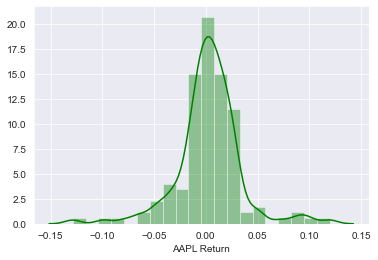

In [7]:
sns.distplot(returns['AAPL Return'],color='green',bins=20)

In [8]:
def get_sector(stock):
    return [x for x in stocks_df[stocks_df['Symbol'] == stock]['GICS Sector']]

stock_info_df = pd.DataFrame.from_dict(discount_dict, orient='index').reset_index()
stock_info_df.columns = ['ticker', 'discount']
stock_info_df['sector'] = [get_sector(tick)[0] for tick in stock_info_df['ticker']]

# add name of the ticker too
def get_stockname(ticker):
    return [x for x in stocks_df[stocks_df['Symbol'] == ticker]['Security']][0]

std_list = []

for tick in stock_info_df['ticker']:
    std_list.append(returns[tick + ' Return'].std()) # risk metric
    
stock_info_df['risk'] = std_list
    
current_price = [stock_dict[tick]['Adj Close'].iloc[-1] for tick in stock_info_df['ticker']]
stock_info_df['current_price'] = current_price
stock_info_df.head()

,ticker,discount,sector,risk,current_price
0,MMM,0.294391,Industrials,0.028941,157.309998
1,ABT,0.307543,Health Care,0.029377,91.510002
2,ABBV,0.299314,Health Care,0.025859,98.257401
3,ABMD,0.312780,Health Care,0.032404,255.794998
4,ACN,0.310097,Information Technology,0.031529,208.940002


In [9]:
stock_info_df.groupby('sector').describe()['discount']

,count,mean,std,min,25%,50%,75%,max
sector,,,,,,,,
Communication Services,26.0,0.359745,0.120882,0.159825,0.264466,0.341208,0.431558,0.692321
Consumer Discretionary,63.0,0.503089,0.147482,0.168449,0.402344,0.495020,0.585443,0.858212
Consumer Staples,32.0,0.291351,0.136609,0.094320,0.200574,0.256447,0.341091,0.700493
Energy,26.0,0.645432,0.128041,0.300362,0.571618,0.628171,0.748027,0.855077
Financials,65.0,0.454171,0.111079,0.173703,0.382437,0.444338,0.534243,0.707074
Health Care,61.0,0.325398,0.085304,0.175692,0.254667,0.315828,0.374383,0.529811
Industrials,72.0,0.404317,0.120175,0.210750,0.325295,0.395569,0.454832,0.760979
Information Technology,71.0,0.353786,0.101740,0.202848,0.296171,0.321958,0.381395,0.785244
Materials,28.0,0.421370,0.105871,0.259173,0.335282,0.427621,0.489565,0.639083


In [10]:
stock_info_df.groupby('sector').describe()['risk']

,count,mean,std,min,25%,50%,75%,max
sector,,,,,,,,
Communication Services,26.0,0.034653,0.008937,0.019210,0.028332,0.034372,0.037767,0.057516
Consumer Discretionary,63.0,0.046490,0.015740,0.019185,0.035800,0.044008,0.051755,0.098844
Consumer Staples,32.0,0.030292,0.010596,0.022025,0.024056,0.027203,0.031700,0.076264
Energy,26.0,0.059532,0.013794,0.037099,0.050676,0.056651,0.069818,0.093969
Financials,65.0,0.043711,0.009162,0.027507,0.037069,0.043604,0.050122,0.071533
Health Care,61.0,0.032205,0.005873,0.021075,0.028549,0.030953,0.034011,0.050641
Industrials,72.0,0.039193,0.012639,0.021866,0.031530,0.035932,0.042571,0.085618
Information Technology,71.0,0.037619,0.008690,0.025651,0.032639,0.036576,0.040616,0.077234
Materials,28.0,0.039968,0.007169,0.029491,0.034209,0.039003,0.042723,0.058277


## Top 5 by Sector

In [11]:
def top5_sector(sector, metric, asc = False):
    cols = ['ticker', 'discount', 'risk', 'current_price']
    return stock_info_df[stock_info_df['sector'] == sector][cols].sort_values(by = metric, ascending = asc).head(5)

In [12]:
top5_sector('Communication Services', 'risk', True)

,ticker,discount,risk,current_price
469,VZ,0.159825,0.019210,55.509998
98,CHTR,0.284800,0.025616,519.715027
166,EA,0.252900,0.025902,133.179993
24,GOOG,0.264172,0.027224,1461.189941
23,GOOGL,0.265348,0.027527,1459.630005


In [13]:
top5_sector('Information Technology', 'discount', False)

,ticker,discount,risk,current_price
20,ADS,0.785244,0.077234,48.070000
158,DXC,0.731236,0.074940,15.710000
495,XRX,0.589391,0.047756,16.330000
486,WDC,0.539372,0.049797,44.220001
194,FLIR,0.514277,0.042401,39.810001
